## Modeling

### Prophet Research

**Install Notes:**
- Numpy
  - Numpy is 1.23.0
  - scipy wants < 1.23.0
  - numba wants < 1.21
- daal4py
  - wants daal==2021.2.3 (which isn't installed)
- Plotly
  - may need to install to utilize some of the interactive figures

**DataFrame Prep:**
- Needs Pandas dataframe with 2 columns:
  - 'ds': datestamp that pandas recognizes
    - Says preferrably YYYY-MM-DD HH:MM:SS for timestamp, but hoping it takes time zone aware stuff
  - 'y': the target variable we want to forecast
    - if these are the only inputs, then I wonder if we can include temperatures :(
    
**Hyperparameters:**

- growth='linear'
  - Leave as linear since we don't have a market cap
- changepoints=None
  - Check out changepoints after first run or so
  - 1 person recommended 1 change point per month
  - but, this read almost like I could add a harvey thing in at first
- n_changepoints=25
- changepoint_range=0.8
- yearly_seasonality='auto'
- weekly_seasonality='auto'
- daily_seasonality='auto'
  - One recommendation was to set these to false then make our own
  - definitely want an hourly representation (which may really mean daily - as it repeats each day)
    - add seasonality probably with daily and fourier_order of 2-10 (probably on the lower side of that)
    - probably want something similar with the yearly - based off monthly plots, probably double whatever the appropriate hourly number should be
- holidays=None
  - NEEDS to be in hourly form
- seasonality_mode='additive'
  - stick with additive, but may want to check out a multiplicative
- seasonality_prior_scale=10.0
- holidays_prior_scale=10.0
  - try multiple values here.  
- changepoint_prior_scale=0.05
- mcmc_samples=0
- interval_width=0.8
- uncertainty_samples=1000
- stan_backend=None

**Cross_valdiation:**
- Parameters:
  - horizon: forecast time period (3 days?)
  - initial: initial training period (3 years? - minimum training window?)
  - period: spacing between cutoff dates
- Example:
  - from prophet.diagnostics import cross_validation
  - df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  
    
**Regression:**
- Looks like we should be able to add weather data via add_regressors
  - Read up on [this article](https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda)
  - Non-continuous variable: would need to bucket temperatures:
    - Maybe: is hot day? or is cold day?
    - Should this is hot/is cold be based on time of day?  would need to see inflection point for that


In [75]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import wrangle

### Prophet Planning:

1. Create reshape dataframe function >> [jump to](#1)
2. Perform Basic Prophet model >> [jump to](#2) 
  - Use default 
  - Store performance variables
3. Add Prophet parameters >> [jump to](#3)
  - Holidays
  - Growth (ex: logistic) 
    - seems to be for market size info, probably inappropriate for us
    - want linear (default)
4. Perform Basic Prophet model w/ cross-validation
  - Use same parameters as #2
  - Add in cross-validation to get aggregated performance
  - sliding window if possible
5. Modify reshape function to add in a regressor

### 1) Create a reshape dataframe <a class='anchor' id='1'></a>

[Next](#2)

- need 'ds' column (start with UTC)
- need 'y' column (ercot load)

In [2]:
df = wrangle.get_combined_df()
df.index

DatetimeIndex(['2010-01-01 00:00:00-06:00', '2010-01-01 01:00:00-06:00',
               '2010-01-01 02:00:00-06:00', '2010-01-01 03:00:00-06:00',
               '2010-01-01 04:00:00-06:00', '2010-01-01 05:00:00-06:00',
               '2010-01-01 06:00:00-06:00', '2010-01-01 07:00:00-06:00',
               '2010-01-01 08:00:00-06:00', '2010-01-01 09:00:00-06:00',
               ...
               '2022-06-30 14:00:00-05:00', '2022-06-30 15:00:00-05:00',
               '2022-06-30 16:00:00-05:00', '2022-06-30 17:00:00-05:00',
               '2022-06-30 18:00:00-05:00', '2022-06-30 19:00:00-05:00',
               '2022-06-30 20:00:00-05:00', '2022-06-30 21:00:00-05:00',
               '2022-06-30 22:00:00-05:00', '2022-06-30 23:00:00-05:00'],
              dtype='datetime64[ns, US/Central]', name='datetime', length=109535, freq=None)

In [3]:
df.columns

Index(['ercot_load', 'dow', 'is_weekday', 'is_obs_holiday', 'hs_temp',
       'hs_feelslike', 'hs_dew', 'hs_humidity', 'hs_precip', 'hs_windgust',
       'hs_windspeed', 'hs_winddir', 'hs_sealevelpressure', 'hs_cloudcover',
       'hs_visibility', 'hs_solarradiation', 'hs_solarenergy', 'hs_uvindex',
       'gv_temp', 'gv_feelslike', 'gv_dew', 'gv_humidity', 'gv_precip',
       'gv_windgust', 'gv_windspeed', 'gv_winddir', 'gv_sealevelpressure',
       'gv_cloudcover', 'gv_visibility', 'gv_solarradiation', 'gv_solarenergy',
       'gv_uvindex', 'pl_temp', 'pl_feelslike', 'pl_dew', 'pl_humidity',
       'pl_precip', 'pl_windgust', 'pl_windspeed', 'pl_winddir',
       'pl_sealevelpressure', 'pl_cloudcover', 'pl_visibility',
       'pl_solarradiation', 'pl_solarenergy', 'pl_uvindex', 'vc_temp',
       'vc_feelslike', 'vc_dew', 'vc_humidity', 'vc_precip', 'vc_windgust',
       'vc_windspeed', 'vc_winddir', 'vc_sealevelpressure', 'vc_cloudcover',
       'vc_visibility', 'vc_solarradiation', '

In [4]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = df.index.copy()
prophet_df['y'] = df.ercot_load.copy()

In [5]:
prophet_df

,ds,y
0,2010-01-01 00:00:00-06:00,NaN
1,2010-01-01 01:00:00-06:00,NaN
2,2010-01-01 02:00:00-06:00,NaN
3,2010-01-01 03:00:00-06:00,NaN
4,2010-01-01 04:00:00-06:00,NaN
...,...,...
109530,2022-06-30 19:00:00-05:00,NaN
109531,2022-06-30 20:00:00-05:00,NaN
109532,2022-06-30 21:00:00-05:00,NaN
109533,2022-06-30 22:00:00-05:00,NaN


In [6]:
#probably an index problem above, so instead:
df2 = pd.DataFrame(df.ercot_load)

In [7]:
df2 #now just need to move datetime to a column and relabel columns

,ercot_load
datetime,
2010-01-01 00:00:00-06:00,7931.241900
2010-01-01 01:00:00-06:00,7775.456846
2010-01-01 02:00:00-06:00,7704.815982
2010-01-01 03:00:00-06:00,7650.575724
2010-01-01 04:00:00-06:00,7666.708317
...,...
2022-06-30 19:00:00-05:00,15040.841510
2022-06-30 20:00:00-05:00,14700.132848
2022-06-30 21:00:00-05:00,14637.633680


In [8]:
df2.reset_index(drop=False, inplace=True)

In [9]:
df2.info() #cool, preserved tz aware datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype                     
---  ------      --------------   -----                     
 0   datetime    109535 non-null  datetime64[ns, US/Central]
 1   ercot_load  109535 non-null  float64                   
dtypes: datetime64[ns, US/Central](1), float64(1)
memory usage: 1.7 MB


In [10]:
df2.rename(columns = {'datetime':'ds','ercot_load':'y'},inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype                     
---  ------  --------------   -----                     
 0   ds      109535 non-null  datetime64[ns, US/Central]
 1   y       109535 non-null  float64                   
dtypes: datetime64[ns, US/Central](1), float64(1)
memory usage: 1.7 MB


###### Drop into a function

In [11]:
def get_prophet_df():
    '''
    Retrieves a cleaned dataframe and formats it for input into
    the FB Prophet model.
    
    NOTE: Prophet does not support timezone - need it in UTC, then make tz naive
    '''
    #Acquire combined dataframe
    df = wrangle.get_combined_df(get_central = False)
    #Pull index/load data into new 
    df2 = pd.DataFrame(df.ercot_load)
    #Move index out
    df2.reset_index(drop=False, inplace=True)
    #Rename columns
    df2.rename(columns = {'datetime':'ds','ercot_load':'y'},inplace=True)
    #Make TZ naive
    df2.ds = df2.ds.dt.tz_localize(None)
    
    return df2
    
    

In [12]:
test = get_prophet_df()

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      109535 non-null  datetime64[ns]
 1   y       109535 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [14]:
test.head(2)

,ds,y
0,2010-01-01 06:00:00,7931.241900
1,2010-01-01 07:00:00,7775.456846


### 2) Exploring the Basic Prophet Model <a class='anchor' id='2'></a>

In [15]:
df = wrangle.get_prophet_df()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      109535 non-null  datetime64[ns]
 1   y       109535 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [17]:
train = df[df.ds < '2018-01-01 06:00:00']
train

,ds,y
0,2010-01-01 06:00:00,7931.241900
1,2010-01-01 07:00:00,7775.456846
2,2010-01-01 08:00:00,7704.815982
3,2010-01-01 09:00:00,7650.575724
4,2010-01-01 10:00:00,7666.708317
...,...,...
70123,2018-01-01 01:00:00,12061.549401
70124,2018-01-01 02:00:00,12015.663549
70125,2018-01-01 03:00:00,11883.114122
70126,2018-01-01 04:00:00,11754.250889


In [18]:
from prophet import Prophet

In [19]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [20]:
model = Prophet()
type(model)

prophet.forecaster.Prophet

In [21]:
model.fit(train)

08:56:05 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
#It doesn't let me pass in 0 periods for the future
#So instead, just grabbing 3 days
future = model.make_future_dataframe(periods=0,freq='H', include_history=True)
future

,ds
0,2010-01-01 06:00:00
1,2010-01-01 07:00:00
2,2010-01-01 08:00:00
3,2010-01-01 09:00:00
4,2010-01-01 10:00:00
...,...
70123,2018-01-01 01:00:00
70124,2018-01-01 02:00:00
70125,2018-01-01 03:00:00
70126,2018-01-01 04:00:00


In [23]:
#Let's see the forecast for the last 3 days
per3 = 24*3
per365 = 24*365
forecast3 = model.predict(future[-per3:])
forecast = model.predict(future[-per365:])
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8755,2018-01-01 01:00:00,12098.657955,10196.691281,13257.016996,12098.657955,12098.657955,-405.646100,-405.646100,-405.646100,1347.131732,...,-424.960641,-424.960641,-424.960641,-1327.817191,-1327.817191,-1327.817191,0.0,0.0,0.0,11693.011854
8756,2018-01-01 02:00:00,12098.688428,9889.144036,13050.061470,12098.688428,12098.688428,-591.519098,-591.519098,-591.519098,1124.830350,...,-389.541322,-389.541322,-389.541322,-1326.808126,-1326.808126,-1326.808126,0.0,0.0,0.0,11507.169330
8757,2018-01-01 03:00:00,12098.718902,9674.039092,12762.474803,12098.718902,12098.718902,-943.120947,-943.120947,-943.120947,735.894212,...,-353.215655,-353.215655,-353.215655,-1325.799504,-1325.799504,-1325.799504,0.0,0.0,0.0,11155.597955
8758,2018-01-01 04:00:00,12098.749375,9081.553725,12279.000838,12098.749375,12098.749375,-1485.064549,-1485.064549,-1485.064549,155.954187,...,-316.227373,-316.227373,-316.227373,-1324.791363,-1324.791363,-1324.791363,0.0,0.0,0.0,10613.684827
8759,2018-01-01 05:00:00,12098.779849,8365.242194,11462.254959,12098.779849,12098.779849,-2148.727872,-2148.727872,-2148.727872,-546.122695,...,-278.821435,-278.821435,-278.821435,-1323.783743,-1323.783743,-1323.783743,0.0,0.0,0.0,9950.051977


**Plot Method Notes**

plot(self, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6), include_legend=False)
 - Plot the Prophet forecast.

**Parameters**


 - fcst: pd.DataFrame output of self.predict.
 - ax: Optional matplotlib axes on which to plot.
 - uncertainty: Optional boolean to plot uncertainty intervals.
 - plot_cap: Optional boolean indicating if the capacity should be shown in the figure, if available.
 - xlabel: Optional label name on X-axis
 - ylabel: Optional label name on Y-axis
 - figsize: Optional tuple width, height in inches.
 - include_legend: Optional boolean to add legend to the plot.

----------
**Returns**
 - A matplotlib figure.

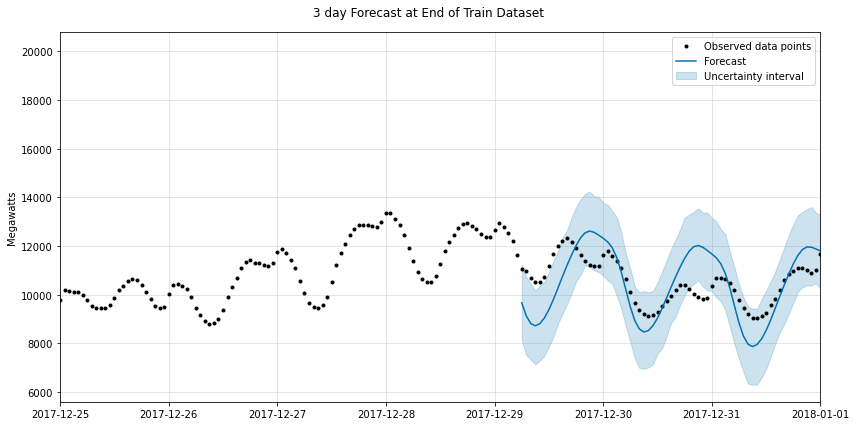

In [24]:
#plot the forecast
fig = model.plot(forecast3,xlabel=None,ylabel='Megawatts',include_legend=True,figsize=(12,6))
fig.suptitle('3 day Forecast at End of Train Dataset')
ax = fig.gca()
#filter to last week
ax.set_xlim((datetime.date(2017,12,25),datetime.date(2018,1,1)));
plt.tight_layout()

<div class="alert alert-info"><b>MODELING NOTES:</b> 
<ul>
    <li>This is clearly not making use of the most recent part of the time series to inform the predictions.  <b>ACTUALLY - it seems to be using the last time and forecasting backwards!</b></li>
    <li>It also seems to be doing a lower fourier_order than what appears to be needed for this daily section.  However, that is a nonstandard day pattern according to our exploration plots of daily load.  Can I pull out the seasonality settings for this model?</li>
    </ul></div>


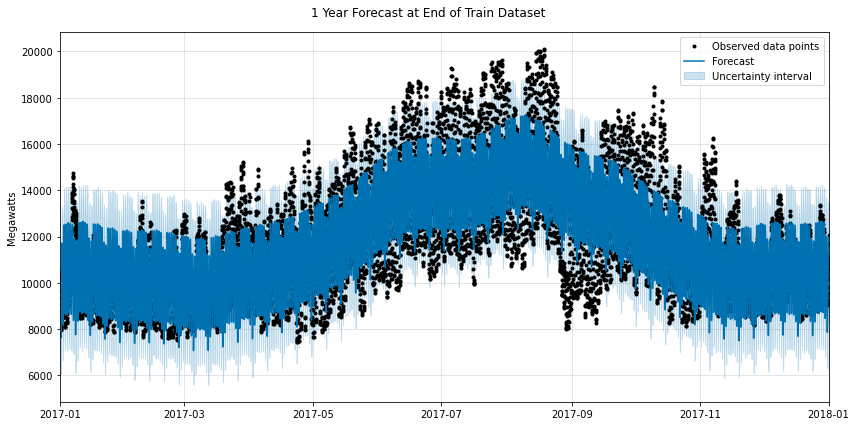

In [25]:
#Let's look at the last year to see how that trend goes
fig = model.plot(forecast,xlabel=None,ylabel='Megawatts',include_legend=True,figsize=(12,6))
fig.suptitle('1 Year Forecast at End of Train Dataset')
ax = fig.gca()
#filter to last week
ax.set_xlim((datetime.date(2017,1,1),datetime.date(2018,1,1)));
plt.tight_layout()

**plot_components method documentation**

plot_components(self, fcst, uncertainty=True, plot_cap=True, weekly_start=0, yearly_start=0, figsize=None)
- Plot the Prophet forecast components. Will plot whichever are available of: trend, holidays, weekly seasonality, and yearly seasonality.
----------
**Parameters**

- fcst: pd.DataFrame output of self.predict.
- uncertainty: Optional boolean to plot uncertainty intervals.
- plot_cap: Optional boolean indicating if the capacity should be shown in the figure, if available.
- weekly_start: Optional int specifying the start day of the weekly  seasonality plot. 0 (default) starts the week on Sunday. 1 shifts by 1 day to Monday, and so on.
- yearly_start: Optional int specifying the start day of the yearly seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts by 1 day to Jan 2, and so on.
- figsize: Optional tuple width, height in inches.
----------
**Returns**
- A matplotlib figure.

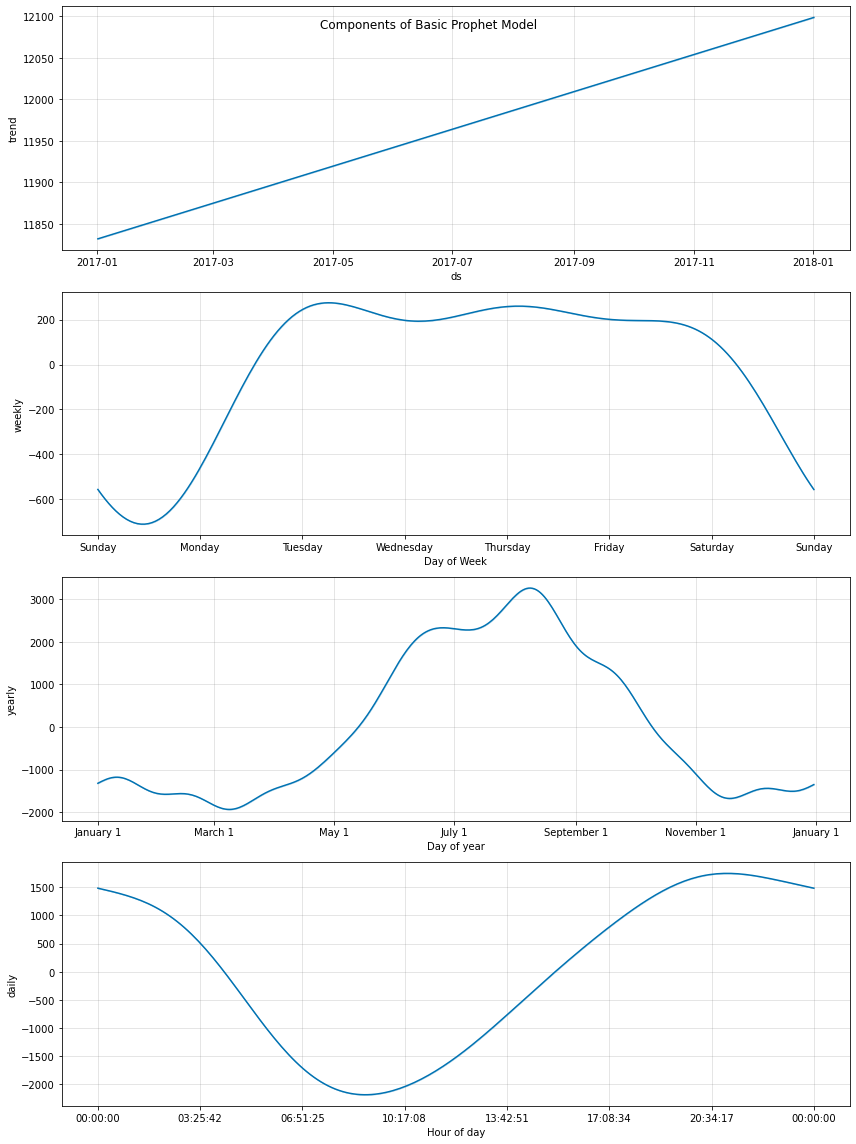

In [26]:
#That looks TERRIBLE, instead plot the seasonal components
fig = model.plot_components(forecast,plot_cap=False,figsize=(12,16))
fig.suptitle('Components of Basic Prophet Model');

In [27]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('daily',
              {'period': 1,
               'fourier_order': 4,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

<div class="alert alert-info"><b>SEASONALITY NOTES:</b> 
<ul>
    <li>The daily fourier_order of 4 seems insufficient, so we may want to increase that. HOWEVER, this may be a product of other parts of the year exhibiting a lower order.  Once we add holidays, this may change. </li>
    <li>The yearly fourier_order of 10 seems overweight.  LIkely overfitting.  Once we add regressors, we may also want to reduce the scale on this.</li>
    <li>The weekly order of 3 seems too low.  It may also be because of the transition though.  Having a curve here </li>
    </ul></div>

<div class="alert alert-warning"><b>CHANGE IN PLAN:</b> 
<ul>
    <li>Is suspect the use of cross-validation will remove the start point problems I saw in the 3 day forecast.  <b>Switching to add cross-validation next</b></li>
    <li>After cross-validation, I will <b>redo the seasonality work</b>, then make decisions on hyperparameters</li>
    <li>Lastly, I need to get some <b>model performance stats</b> and dig into that.</li>
    </ul></div>

### Cross Validation


**Parameter Decisions**

- 

*See help text below*

Both of these seem to indicate that cross-validation uses a sliding window:
- https://stackoverflow.com/questions/62568813/struggling-to-understand-the-parameters-of-the-cross-validation-function-in-fbpr
- https://stackoverflow.com/questions/70070734/understanding-fbprophet-cross-validation

In [28]:
from prophet.diagnostics import cross_validation

In [29]:
help(cross_validation)

Help on function cross_validation in module prophet.diagnostics:

cross_validation(model, horizon, period=None, initial=None, parallel=None, cutoffs=None, disable_tqdm=False)
    Cross-Validation for time series.
    
    Computes forecasts from historical cutoff points, which user can input.
    If not provided, begins from (end - horizon) and works backwards, making
    cutoffs with a spacing of period until initial is reached.
    
    When period is equal to the time interval of the data, this is the
    technique described in https://robjhyndman.com/hyndsight/tscv/ .
    
    Parameters
    ----------
    model: Prophet class object. Fitted Prophet model.
    horizon: string with pd.Timedelta compatible style, e.g., '5 days',
        '3 hours', '10 seconds'.
    period: string with pd.Timedelta compatible style. Simulated forecast will
        be done at every this period. If not provided, 0.5 * horizon is used.
    initial: string with pd.Timedelta compatible style. The first tra

In [30]:
#initialize and fit model
model = Prophet().fit(train)

08:56:36 - cmdstanpy - INFO - Chain [1] start processing
08:57:00 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
# model: Prophet class object. Fitted Prophet model.
#     horizon: string with pd.Timedelta compatible style, e.g., '5 days',
#         '3 hours', '10 seconds'.
#     period: string with pd.Timedelta compatible style. Simulated forecast will
#         be done at every this period. If not provided, 0.5 * horizon is used.
#     initial: string with pd.Timedelta compatible style. The first training
#         period will include at least this much data. If not provided,
#         3 * horizon is used.
#     cutoffs: list of pd.Timestamp specifying cutoffs to be used during
#         cross validation. If not provided, they are generated as described
#         above.

#Create cross_validation dataframe
#COMMENTED OUT SO I DON'T ACCIDENTLY RUN - TAKES 35 MINUTES
#df_cv = cross_validation(model, initial='2556 days', period='3 days', horizon = '3 days')

  0%|          | 0/121 [00:00<?, ?it/s]

14:12:23 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:42 - cmdstanpy - INFO - Chain [1] start processing
14:13:04 - cmdstanpy - INFO - Chain [1] done processing
14:13:07 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing
14:13:27 - cmdstanpy - INFO - Chain [1] start processing
14:13:39 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:59 - cmdstanpy - INFO - Chain [1] start processing
14:14:15 - cmdstanpy - INFO - Chain [1] done processing
14:14:17 - cmdstanpy - INFO - Chain [1] start processing
14:14:33 - cmdstanpy - INFO - Chain [1] done processing
14:14:34 - cmdstanpy - INFO - Chain [1] start processing
14:14:49 - cmdstanpy - INFO - Chain [1] done processing
14:14:51 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1]

14:33:50 - cmdstanpy - INFO - Chain [1] done processing
14:33:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:09 - cmdstanpy - INFO - Chain [1] done processing
14:34:11 - cmdstanpy - INFO - Chain [1] start processing
14:34:26 - cmdstanpy - INFO - Chain [1] done processing
14:34:27 - cmdstanpy - INFO - Chain [1] start processing
14:34:42 - cmdstanpy - INFO - Chain [1] done processing
14:34:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:01 - cmdstanpy - INFO - Chain [1] done processing
14:35:03 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing
14:35:38 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:12 - cmdstanpy - INFO - Chain [1] done processing
14:36:14 - cmdstanpy - INFO - Chain [1] 

In [37]:
df_cv.shape

(8712, 6)

In [38]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-03 06:00:00,9729.298901,8258.246742,11068.671342,8935.488453,2017-01-03 05:00:00
1,2017-01-03 07:00:00,9192.820456,7653.812553,10722.122682,8516.587483,2017-01-03 05:00:00
2,2017-01-03 08:00:00,8878.103469,7335.752406,10370.846415,8238.178522,2017-01-03 05:00:00
3,2017-01-03 09:00:00,8785.831154,7243.375448,10217.491388,8102.776236,2017-01-03 05:00:00
4,2017-01-03 10:00:00,8876.016050,7432.240930,10394.419450,8094.303490,2017-01-03 05:00:00


In [39]:
#pull in the performance metrics
from prophet.diagnostics import performance_metrics

In [40]:
help(performance_metrics)

Help on function performance_metrics in module prophet.diagnostics:

performance_metrics(df, metrics=None, rolling_window=0.1, monthly=False)
    Compute performance metrics from cross-validation results.
    
    Computes a suite of performance metrics on the output of cross-validation.
    By default the following metrics are included:
    'mse': mean squared error
    'rmse': root mean squared error
    'mae': mean absolute error
    'mape': mean absolute percent error
    'mdape': median absolute percent error
    'smape': symmetric mean absolute percentage error
    'coverage': coverage of the upper and lower intervals
    
    A subset of these can be specified by passing a list of names as the
    `metrics` argument.
    
    Metrics are calculated over a rolling window of cross validation
    predictions, after sorting by horizon. Averaging is first done within each
    value of horizon, and then across horizons as needed to reach the window
    size. The size of that window (n

In [41]:
#lets see default (all metrics, .1 rolling window)
df_p = performance_metrics(df_cv)
df_p.shape

(65, 8)

In [42]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 08:00:00,1.326266e+06,1151.636239,891.772305,0.088737,0.074153,0.087012,0.839294
1,0 days 09:00:00,1.358632e+06,1165.603622,899.309055,0.088386,0.071698,0.086535,0.835394
2,0 days 10:00:00,1.351820e+06,1162.677949,889.390941,0.085842,0.069147,0.083912,0.831257
3,0 days 11:00:00,1.349231e+06,1161.564212,886.405821,0.083132,0.066682,0.081271,0.830574
4,0 days 12:00:00,1.392500e+06,1180.042355,905.446111,0.081649,0.067609,0.080004,0.824606
...,...,...,...,...,...,...,...,...
60,2 days 20:00:00,2.550446e+06,1597.011620,1314.757658,0.099509,0.087799,0.097763,0.631752
61,2 days 21:00:00,2.430367e+06,1558.963490,1271.358877,0.096485,0.083503,0.094808,0.652200
62,2 days 22:00:00,2.232561e+06,1494.175549,1204.352179,0.092145,0.075902,0.090594,0.691254
63,2 days 23:00:00,1.987720e+06,1409.865398,1121.767296,0.087271,0.070582,0.085813,0.734892


In [43]:
metrics = ['rmse','mape', 'mdape','coverage']
df_p_all = performance_metrics(df_cv,rolling_window=1,metrics=metrics)

In [44]:
df_p_all

,horizon,rmse,mape,mdape,coverage
0,3 days,1358.781742,0.089616,0.073867,0.75023


In [45]:
df_p_1d = performance_metrics(df_cv,rolling_window=.33,metrics=metrics)

In [46]:
df_p_1d.head(2)

,horizon,rmse,mape,mdape,coverage
0,1 days 00:00:00,1363.933543,0.089885,0.076264,0.751120
1,1 days 01:00:00,1368.561011,0.090042,0.075969,0.748857


In [47]:
df_p_1d.tail(2)

,horizon,rmse,mape,mdape,coverage
47,2 days 23:00:00,1350.192021,0.090265,0.073001,0.747635
48,3 days 00:00:00,1348.923421,0.090196,0.073860,0.749547


In [48]:
df_cv.head(2)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-03 06:00:00,9729.298901,8258.246742,11068.671342,8935.488453,2017-01-03 05:00:00
1,2017-01-03 07:00:00,9192.820456,7653.812553,10722.122682,8516.587483,2017-01-03 05:00:00


<AxesSubplot:>

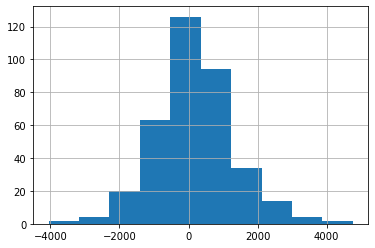

In [49]:
#pull out only the first hour of predictions.  
only_first = df_cv[df_cv.ds.dt.hour == 6]
#We want to see how often the prediction is too low or too high
(only_first.yhat-only_first.y).hist()

metric:
- one or two numbers for both 1 day and 3 days (*df_cv_all*  and  *df_cv_1d[0]*)
:
  - RMSE
  - MAPE
- Further exploration, that identifies when the model does worse:
  - can use df_cv to generate datetype parameters of cutoff and manual error calculations
  - aggregate per model (aka cutoff), then find what cutoffs do worse (and the time periods within them that performe the worst
  - or aggregate by ds datetype data.
  - ALL can inform model tuning and anomalous day modeling.

<div class="alert alert-warning"><b>Planning Future Cross_Validation</b><br><br><b>Notes on previous run</b>
<ul>
    <li>Right now, our trains have a lot of overlap (~6 of 7 years overlap)</li>
    <li>We want more diverse trains, so think about shortening <b>initial</b> parameter to 3 years (currently at 7 years)</li>
    <li>If we just adjusted the initial parameter, we estimate it will take ~3 hours to run.  This is a problem as we will want to run this across potentially 100+ models - with a variety of hyperparameters.</li>
    <li>To avoid that, we need to change our period such that it doesn't try and run a model every 3 days over five years, but rather spaces out our predictions <i>while still capturing a variety of day types</i> (EX: all days of week, all seasons, holidays, different parts of the month, multiple years</li>
    </ul>
    <br><b>Solution: Do a trimmed down Cross-validation on the 100+ models</b>
        <ul>
            <li>Lower processing time, then can choose top 5-10 best models and perform the more in-depth cross-validation technique</li>
            <li>Given this, we went with a 4 year train, 3 day forecast, 36 day slide to the next split </li>
            <li>36 day slider makes sure we rotate through all seasons, all times of the month and all days of the week.</li>
            <li>We tried 25 days, but didn't cut down the run time as much as we hopped, so 36!</li>
    </ul>
<br>
    <b>MAKE SURE our Baseline and Holts-Winters also use the EXACT SAME splits</b>.  Otherwise our evalutation metrics won't be appropriately comparing model performance</div>
  
**Notes on the convo w/ Adam K**
- Define the sliding period instead of using random date generation
- Choose something not divisible 7, or 30 or 15 (needs to rotate through a month).  25
- certain hyperparameters may perform well on the more sparse cross-validation than it does
  - fewer inputs...don't want to overfit

In [50]:
#Given our concerns
df_cv_25 = cross_validation(model, initial='1461 days', period='25 days', horizon = '3 days') 
# This was supposed to take < 10 minutes, but ended up taking 15 minutes

  0%|          | 0/59 [00:00<?, ?it/s]

10:44:28 - cmdstanpy - INFO - Chain [1] start processing
10:44:38 - cmdstanpy - INFO - Chain [1] done processing
10:44:40 - cmdstanpy - INFO - Chain [1] start processing
10:44:48 - cmdstanpy - INFO - Chain [1] done processing
10:44:49 - cmdstanpy - INFO - Chain [1] start processing
10:44:56 - cmdstanpy - INFO - Chain [1] done processing
10:44:57 - cmdstanpy - INFO - Chain [1] start processing
10:45:03 - cmdstanpy - INFO - Chain [1] done processing
10:45:04 - cmdstanpy - INFO - Chain [1] start processing
10:45:12 - cmdstanpy - INFO - Chain [1] done processing
10:45:13 - cmdstanpy - INFO - Chain [1] start processing
10:45:25 - cmdstanpy - INFO - Chain [1] done processing
10:45:27 - cmdstanpy - INFO - Chain [1] start processing
10:45:36 - cmdstanpy - INFO - Chain [1] done processing
10:45:38 - cmdstanpy - INFO - Chain [1] start processing
10:45:52 - cmdstanpy - INFO - Chain [1] done processing
10:45:53 - cmdstanpy - INFO - Chain [1] start processing
10:46:02 - cmdstanpy - INFO - Chain [1]

In [51]:
df_25_p_1d = performance_metrics(df_cv_25,rolling_window=.33,metrics=metrics)
df_25_p_3d = performance_metrics(df_cv_25,rolling_window=1,metrics=metrics)

In [52]:
df_25_p_1d.head(1)

,horizon,rmse,mape,mdape,coverage
0,1 days,1394.07886,0.098098,0.082211,0.706311


In [53]:
df_25_p_3d

,horizon,rmse,mape,mdape,coverage
0,3 days,1380.093089,0.097428,0.082356,0.730226


In [54]:
#Given our concerns
df_cv_36 = cross_validation(model, initial='1461 days', period='36 days', horizon = '3 days') 
# This was supposed to take < 8 minutes, and ended up taking 11 minutes 

  0%|          | 0/41 [00:00<?, ?it/s]

11:28:45 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing
11:28:56 - cmdstanpy - INFO - Chain [1] start processing
11:29:04 - cmdstanpy - INFO - Chain [1] done processing
11:29:06 - cmdstanpy - INFO - Chain [1] start processing
11:29:17 - cmdstanpy - INFO - Chain [1] done processing
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
11:29:31 - cmdstanpy - INFO - Chain [1] done processing
11:29:32 - cmdstanpy - INFO - Chain [1] start processing
11:29:43 - cmdstanpy - INFO - Chain [1] done processing
11:29:45 - cmdstanpy - INFO - Chain [1] start processing
11:29:56 - cmdstanpy - INFO - Chain [1] done processing
11:29:58 - cmdstanpy - INFO - Chain [1] start processing
11:30:07 - cmdstanpy - INFO - Chain [1] done processing
11:30:08 - cmdstanpy - INFO - Chain [1] start processing
11:30:22 - cmdstanpy - INFO - Chain [1] done processing
11:30:23 - cmdstanpy - INFO - Chain [1] start processing
11:30:35 - cmdstanpy - INFO - Chain [1]

In [55]:
df_36_p_1d = performance_metrics(df_cv_36,rolling_window=.33,metrics=metrics)
df_36_p_3d = performance_metrics(df_cv_36,rolling_window=1,metrics=metrics)

In [56]:
df_36_p_1d.head(1)

,horizon,rmse,mape,mdape,coverage
0,1 days,1219.915295,0.081049,0.069937,0.786948


In [57]:
df_36_p_3d

,horizon,rmse,mape,mdape,coverage
0,3 days,1302.311727,0.085275,0.070506,0.757791


##### Plot the crossvalidation performance

In [58]:
from prophet.plot import plot_cross_validation_metric

In [59]:
help(plot_cross_validation_metric)

Help on function plot_cross_validation_metric in module prophet.plot:

plot_cross_validation_metric(df_cv, metric, rolling_window=0.1, ax=None, figsize=(10, 6), color='b', point_color='gray')
    Plot a performance metric vs. forecast horizon from cross validation.
    
    Cross validation produces a collection of out-of-sample model predictions
    that can be compared to actual values, at a range of different horizons
    (distance from the cutoff). This computes a specified performance metric
    for each prediction, and aggregated over a rolling window with horizon.
    
    This uses prophet.diagnostics.performance_metrics to compute the metrics.
    Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.
    
    rolling_window is the proportion of data included in the rolling window of
    aggregation. The default value of 0.1 means 10% of data are included in the
    aggregation for computing the metric.
    
    As a concrete example, if metric='mse', then th

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


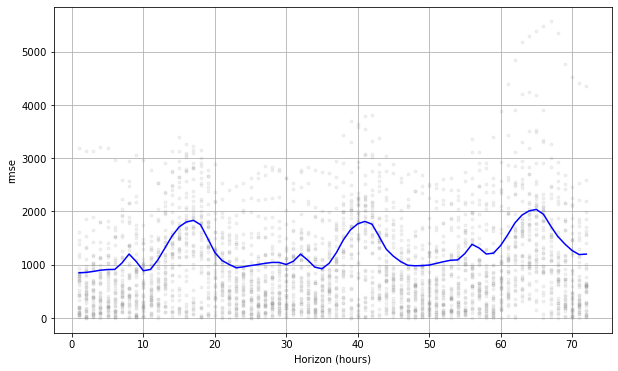

In [60]:
fig = plot_cross_validation_metric(df_cv_36, rolling_window=0, metric='rmse')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


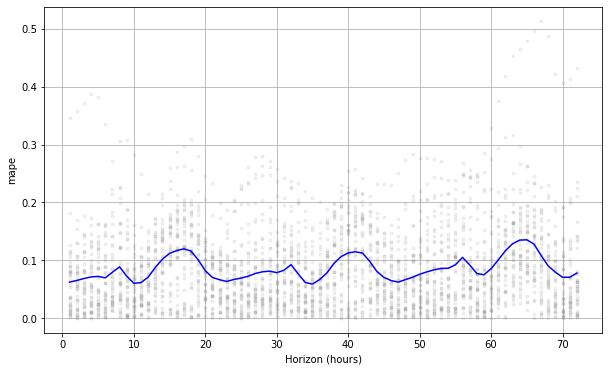

In [61]:
fig = plot_cross_validation_metric(df_cv_36, rolling_window=0, metric='mape')

<div class="alert alert-info"><b>Cross_Validation Notes</b><br><br><b>Notes on previous run</b>
<ul>
    <li>Went with 36 day rolling period</li>
    <li>Noticed that model consistently performed better as we reduced the amount of cross-validation periods. (likely not catching as many anomolous days.</li>
    <li>Plot of RMSE shows clear daily seasonality that isn't being caught (need to increase daily scale)</li>
    <li>Likely going with RMSE and MAPE or MDAPE - <b>NOTE:</b> MAPE and MDAPE will slightly favor models that underestimate.  (negative errors have a lower weight than positive errors as they max out at 100%)</li>
    </ul>
    

### Prophet with initial set of hyperparameters

- Add Seasonality
- Add Holiday
- Add Regressors

##### Prep Regressors

In [81]:
def get_prophet_df_w_meantemp():
    '''
    Retrieves a cleaned dataframe and formats it for input into
    the FB Prophet model.
    
    NOTE: Prophet does not support timezone - need it in UTC, then make tz naive
    '''
    #Acquire combined dataframe
    df = wrangle.get_combined_df(get_central = False)
    #Calculate mean_temp column
    df['mean_temp'] = (df.hs_temp + df.gv_temp + df.pl_temp + df.vc_temp)/4

    #Pull index/load/temp data into new dataframe
    df2 = pd.DataFrame(df[['ercot_load','mean_temp']])
    
    #Move index out
    df2.reset_index(drop=False, inplace=True)
    #Rename columns
    df2.rename(columns = {'datetime':'ds','ercot_load':'y'},inplace=True)
    #Make TZ naive
    df2.ds = df2.ds.dt.tz_localize(None)
    
    return df2

In [84]:
#get new df with the meantemp column
dfr = get_prophet_df_w_meantemp()

trainr = dfr[dfr.ds < '2018-01-01 06:00:00']

In [85]:
trainr

,ds,y,mean_temp
0,2010-01-01 06:00:00,7931.241900,49.025
1,2010-01-01 07:00:00,7775.456846,48.025
2,2010-01-01 08:00:00,7704.815982,46.800
3,2010-01-01 09:00:00,7650.575724,45.775
4,2010-01-01 10:00:00,7666.708317,44.925
...,...,...,...
70123,2018-01-01 01:00:00,12061.549401,44.200
70124,2018-01-01 02:00:00,12015.663549,41.925
70125,2018-01-01 03:00:00,11883.114122,40.275
70126,2018-01-01 04:00:00,11754.250889,39.700


##### Prep Holidays

holidays: pd.DataFrame with columns holiday (string) and ds (date type) and optionally columns lower_window and upper_window which specify arange of days around the date to be included as holidays. lower_window=-2 will include 2 days prior to the date as holidays. Also optionally can have a column prior_scale specifying the prior scale for that holiday.

In [73]:
from pandas.tseries.holiday import USFederalHolidayCalendar

#create calendar object
cal = USFederalHolidayCalendar()
#get as list of dates
train_holidays = cal.holidays(start=trainr.ds.min(),end=trainr.ds.max())

In [74]:
train_holidays

DatetimeIndex(['2010-01-18', '2010-02-15', '2010-05-31', '2010-07-05',
               '2010-09-06', '2010-10-11', '2010-11-11', '2010-11-25',
               '2010-12-24', '2010-12-31', '2011-01-17', '2011-02-21',
               '2011-05-30', '2011-07-04', '2011-09-05', '2011-10-10',
               '2011-11-11', '2011-11-24', '2011-12-26', '2012-01-02',
               '2012-01-16', '2012-02-20', '2012-05-28', '2012-07-04',
               '2012-09-03', '2012-10-08', '2012-11-12', '2012-11-22',
               '2012-12-25', '2013-01-01', '2013-01-21', '2013-02-18',
               '2013-05-27', '2013-07-04', '2013-09-02', '2013-10-14',
               '2013-11-11', '2013-11-28', '2013-12-25', '2014-01-01',
               '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04',
               '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27',
               '2014-12-25', '2015-01-01', '2015-01-19', '2015-02-16',
               '2015-05-25', '2015-07-03', '2015-09-07', '2015-10-12',
      

In [98]:
holiday_df.ds.max()

Timestamp('2018-01-01 05:00:00')

In [118]:
holiday_df.ds.dt.date.astype(str).isin(train_holidays.astype(str))
#This works, but it ain't pretty

0        False
1        False
2        False
3        False
4        False
         ...  
70123     True
70124     True
70125     True
70126     True
70127     True
Name: ds, Length: 70128, dtype: bool

In [86]:
# Transition to dataframe with holiday, ds columns
holiday_df = pd.DataFrame(trainr.ds)
holiday_df

,ds
0,2010-01-01 06:00:00
1,2010-01-01 07:00:00
2,2010-01-01 08:00:00
3,2010-01-01 09:00:00
4,2010-01-01 10:00:00
...,...
70123,2018-01-01 01:00:00
70124,2018-01-01 02:00:00
70125,2018-01-01 03:00:00
70126,2018-01-01 04:00:00


In [124]:
holiday_df['holiday'] = holiday_df.ds.dt.date.astype(str).isin(train_holidays.astype(str)).astype(int)

In [125]:
holiday_df.holiday.sum()

1902

In [126]:
holiday_df.holiday.mean()

0.027121834360027377

In [127]:
holiday_df

,ds,holiday
0,2010-01-01 06:00:00,0
1,2010-01-01 07:00:00,0
2,2010-01-01 08:00:00,0
3,2010-01-01 09:00:00,0
4,2010-01-01 10:00:00,0
...,...,...
70123,2018-01-01 01:00:00,1
70124,2018-01-01 02:00:00,1
70125,2018-01-01 03:00:00,1
70126,2018-01-01 04:00:00,1


In [131]:
only_holidays = holiday_df[holiday_df.holiday==1]

In [135]:
only_holidays.holiday = only_holidays.holiday.astype(str)
only_holidays

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ds,holiday
402,2010-01-18 00:00:00,1
403,2010-01-18 01:00:00,1
404,2010-01-18 02:00:00,1
405,2010-01-18 03:00:00,1
406,2010-01-18 04:00:00,1
...,...,...
70123,2018-01-01 01:00:00,1
70124,2018-01-01 02:00:00,1
70125,2018-01-01 03:00:00,1
70126,2018-01-01 04:00:00,1


In [136]:
only_holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 402 to 70127
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       1902 non-null   datetime64[ns]
 1   holiday  1902 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 44.6+ KB


##### Put our hyperparameters together

In [68]:
help(Prophet.add_seasonality)

Help on function add_seasonality in module prophet.forecaster:

add_seasonality(self, name, period, fourier_order, prior_scale=None, mode=None, condition_name=None)
    Add a seasonal component with specified period, number of Fourier
    components, and prior scale.
    
    Increasing the number of Fourier components allows the seasonality to
    change more quickly (at risk of overfitting). Default values for yearly
    and weekly seasonalities are 10 and 3 respectively.
    
    Increasing prior scale will allow this seasonality component more
    flexibility, decreasing will dampen it. If not provided, will use the
    seasonality_prior_scale provided on Prophet initialization (defaults
    to 10).
    
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used (defaults to additive).
    Additive means the seasonality will be added to the trend,
    multiplicative means it will multiply the trend.
    
    If condi

In [137]:
# seasonality mode additive - default
# holiays_prior_scale
# holidays

m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=only_holidays)

m = m.add_seasonality(name='daily', 
                      period=1, 
                      fourier_order=6,
                      prior_scale=30
                     )

m = m.add_seasonality(name='weekly', 
                      period=7, 
                      fourier_order=6,
                      prior_scale=30
                     )
m = m.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=6,
                      prior_scale=10
                     )

m = m.add_regressor('mean_temp')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])


In [138]:
m.fit(trainr)

19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing


In [140]:
df_cv_v2 = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
#says < 8 minutes, was 

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:49:18 - cmdstanpy - INFO - Chain [1] start processing
19:49:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:49:29 - cmdstanpy - INFO - Cha

19:53:10 - cmdstanpy - INFO - Chain [1] start processing
19:53:23 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:53:25 - cmdstanpy - INFO - Chain [1] start processing
19:53:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:58:02 - cmdstanpy - INFO - Chain [1] start processing
19:58:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:58:28 - cmdstanpy - INFO - Cha

In [143]:
df_v2_1d = performance_metrics(df_cv_v2, rolling_window=.33, metrics=metrics)
df_v2_3d = performance_metrics(df_cv_v2, rolling_window=1, metrics=metrics)

In [162]:
performance_metrics(df_cv_v2, rolling_window=.33, metrics=metrics).head(1)

,horizon,rmse,mape,mdape,coverage
0,1 days,1190.961012,0.07978,0.068076,0.775655


In [145]:
df_v2_1d.head(1)

,horizon,rmse,mape,mdape,coverage
0,1 days,1190.961012,0.07978,0.068076,0.775655


In [163]:
df_v2_1d.loc[0,'rmse']

1190.9610119774827

In [164]:
df_v2_3d.loc[0,'rmse']

1279.228370803159

In [146]:
df_v2_3d

,horizon,rmse,mape,mdape,coverage
0,3 days,1279.228371,0.08412,0.070001,0.756775


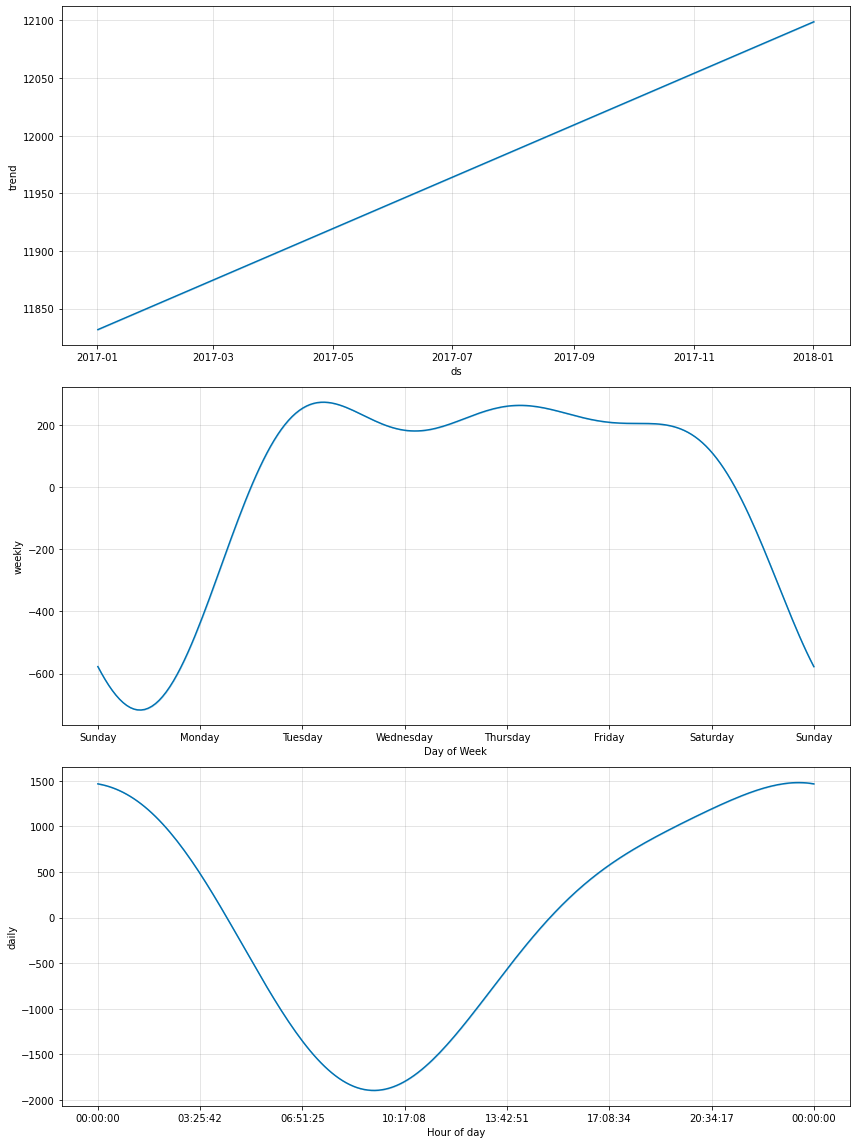

In [196]:
fig = m.plot_components(forecast,plot_cap=False,figsize=(12,16))

In [202]:
import itertools
# daily_scale: 10 - 50
# weekly_scale: 10-50
# yearly_scale: 0-30
# d/w orders: 3-8
# y 0rder: 3-6

d_opts = [10,20,30]
w_opts = [10,20]
reg_scale = [10,30]
d_fo = range(2,4)
w_fo = range(2,4)

param_list = list(itertools.product(d_opts,w_opts,d_fo,d_fo,reg_scale))

In [203]:
len(param_list)

48

In [204]:
param_list[0:3]

[(10, 10, 2, 2, 10), (10, 10, 2, 2, 30), (10, 10, 2, 3, 10)]

In [186]:
#initialize model performance dataframe
model_perf = pd.DataFrame()


In [224]:
#Loop over the parameter combinations
for params in param_list[15:25]:
    #GENERATE MODEL
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=only_holidays)
    #ADD SEASONALITY
    m = m.add_seasonality(name='daily', 
                          period=1, 
                          fourier_order=params[2],
                          prior_scale=params[0]
                         )
    m = m.add_seasonality(name='weekly', 
                          period=7, 
                          fourier_order=params[3],
                          prior_scale=params[1]
                         )
#     m = m.add_seasonality(name='yearly', 
#                           period=365.25, 
#                           fourier_order=params[5],
#                           prior_scale=params[2]
#                          )
    #ADD REGRESSOR
    m = m.add_regressor('mean_temp',prior_scale=params[4])
    
    #FIT MODEL
    m.fit(trainr)
    
    #CREATE CROSS VALIDATION DF
    df_cv_loop = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
    #get 1 day/3day metrics
    df_cv_loop_1d = performance_metrics(df_cv_loop, rolling_window=.33, metrics=metrics)
    df_cv_loop_3d = performance_metrics(df_cv_loop, rolling_window=1, metrics=metrics)
    
    #STORE MODEL PARAMETERS AND PERFORMANCE
    dict = {
        'daily_order': params[2],
        'weekly_order': params[3],
        'daily_scale': params[0],
        'weekly_scale': params[1],
        'regressor_scale':params[4],
        '1d_rmse': df_cv_loop_1d.loc[0,'rmse'],
        '1d_mape': df_cv_loop_1d.loc[0,'mape'],
        '3d_rmse': df_cv_loop_3d.loc[0,'rmse'],
        '3d_mape': df_cv_loop_3d.loc[0,'mape']  
    }
    model_perf = model_perf.append(dict,ignore_index=True)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:20:50 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:21:21 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:21:34 - cmdstanpy - INFO - Cha

18:25:18 - cmdstanpy - INFO - Chain [1] start processing
18:25:37 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:31:27 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:36:29 - cmdstanpy - INFO - Cha

18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:40:23 - cmdstanpy - INFO - Chain [1] start processing
18:40:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:45:41 - cmdstanpy - INFO - Chain [1] start processing
18:46:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:46:08 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:51:00 - cmdstanpy - INFO - Cha

18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:00:31 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:05:10 - cmdstanpy - INFO - Chain [1] start processing
19:05:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:05:22 - cmdstanpy - INFO - Cha

19:09:00 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:14:34 - cmdstanpy - INFO - Chain [1] start processing
19:14:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:14:55 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:19:47 - cmdstanpy - INFO - Chain [1] start processing
19:19:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:19:59 - cmdstanpy - INFO - Cha

19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:23:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:29:49 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:34:37 - cmdstanpy - INFO - Chain [1] start processing
19:34:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:34:48 - cmdstanpy - INFO - Cha

19:39:17 - cmdstanpy - INFO - Chain [1] start processing
19:39:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:39:34 - cmdstanpy - INFO - Chain [1] start processing
19:39:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:45:05 - cmdstanpy - INFO - Chain [1] start processing
19:45:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:45:31 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:50:08 - cmdstanpy - INFO - Chain [1] start processing
19:50:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:50:21 - cmdstanpy - INFO - Cha

19:54:02 - cmdstanpy - INFO - Chain [1] start processing
19:54:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:54:15 - cmdstanpy - INFO - Chain [1] start processing
19:54:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
19:59:54 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:00:23 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:05:26 - cmdstanpy - INFO - Cha

20:09:13 - cmdstanpy - INFO - Chain [1] start processing
20:09:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:15:01 - cmdstanpy - INFO - Chain [1] start processing
20:15:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:15:27 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:20:29 - cmdstanpy - INFO - Cha

20:24:11 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:30:00 - cmdstanpy - INFO - Chain [1] start processing
20:30:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:30:28 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:35:11 - cmdstanpy - INFO - Chain [1] start processing
20:35:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:35:26 - cmdstanpy - INFO - Cha

20:38:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:39:15 - cmdstanpy - INFO - Chain [1] start processing
20:39:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:44:32 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
20:44:58 - cmdstanpy - INFO - Cha

In [229]:
model_perf.sort_values(by='3d_mape')


,daily_order,weekly_order,daily_scale,weekly_scale,1d_rmse,1d_mape,3d_rmse,3d_mape,regressor_scale
6,3.0,3.0,10.0,10.0,1944.309673,0.138053,1864.355851,0.131767,10.0
14,3.0,3.0,10.0,20.0,1943.624456,0.138034,1864.229028,0.131785,10.0
23,3.0,3.0,20.0,10.0,1943.713387,0.138048,1864.389563,0.131831,30.0
22,3.0,3.0,20.0,10.0,1944.136071,0.138119,1864.494436,0.131854,10.0
7,3.0,3.0,10.0,10.0,1945.364661,0.138134,1865.367448,0.131863,30.0
15,3.0,3.0,10.0,20.0,1944.663657,0.138110,1865.147197,0.131865,30.0
19,2.0,3.0,20.0,10.0,1947.499531,0.138174,1868.347769,0.132024,30.0
4,3.0,2.0,10.0,10.0,1945.968977,0.138156,1866.777866,0.132058,10.0
3,2.0,3.0,10.0,10.0,1948.205200,0.138255,1868.960762,0.132084,30.0
2,2.0,3.0,10.0,10.0,1948.656636,0.138279,1869.101163,0.132094,10.0


In [226]:
# model_perf.to_csv('model_perf_0_25.csv',index=False)


In [236]:
#REPEAT with yearly added back in
d_scale = [10]
w_scale = [10]
y_scale = [5, 10]
reg_scale = [10]
d_fo = range(3,6)
w_fo = range(3,5)
y_fo = range(3,6)

param_list2 = list(itertools.product(d_scale,w_scale,y_scale,reg_scale,d_fo,w_fo,y_fo))

In [237]:
len(param_list2)

36

In [238]:
param_list2[0]

(10, 10, 5, 10, 3, 3, 3)

In [235]:
#initialize model performance dataframe
model_perf2 = pd.DataFrame()

In [239]:
#Loop over the parameter combinations
for params in param_list2:
    #GENERATE MODEL
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=only_holidays)
    #ADD SEASONALITY
    m = m.add_seasonality(name='daily', 
                          period=1, 
                          fourier_order=params[4],
                          prior_scale=params[0]
                         )
    m = m.add_seasonality(name='weekly', 
                          period=7, 
                          fourier_order=params[5],
                          prior_scale=params[1]
                         )
    m = m.add_seasonality(name='yearly', 
                          period=365.25, 
                          fourier_order=params[6],
                          prior_scale=params[2]
                         )
    #ADD REGRESSOR
    m = m.add_regressor('mean_temp',prior_scale=params[3])
    
    #FIT MODEL
    m.fit(trainr)
    
    #CREATE CROSS VALIDATION DF
    df_cv_loop = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
    #get 1 day/3day metrics
    df_cv_loop_1d = performance_metrics(df_cv_loop, rolling_window=.33, metrics=metrics)
    df_cv_loop_3d = performance_metrics(df_cv_loop, rolling_window=1, metrics=metrics)
    
    #STORE MODEL PARAMETERS AND PERFORMANCE
    dict = {
        'daily_scale': params[0],
        'weekly_scale': params[1],
        'yearly_scale': params[2],
        'regressor_scale':params[3],
        'daily_order': params[4],
        'weekly_order': params[5],
        'yearly_order': params[6],
        '1d_rmse': df_cv_loop_1d.loc[0,'rmse'],
        '1d_mape': df_cv_loop_1d.loc[0,'mape'],
        '3d_rmse': df_cv_loop_3d.loc[0,'rmse'],
        '3d_mape': df_cv_loop_3d.loc[0,'mape']  
    }
    model_perf2 = model_perf2.append(dict,ignore_index=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:15:25 - cmdstanpy - INFO - Chain [1] start processing
21:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:15:47 - cmdstanpy - INFO - Chain [1] start processing
21:15:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:15:59 - cmdstanpy - INFO - Cha

21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:19:23 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:23:58 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:27:23 - cmdstanpy - INFO - Cha

21:30:45 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:31:05 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:35:24 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:35:51 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:39:24 - cmdstanpy - INFO - Chain [1] start processing
21:39:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:39:33 - cmdstanpy - INFO - Cha

21:43:07 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:48:09 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:51:59 - cmdstanpy - INFO - Cha

21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:55:29 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
21:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:00:11 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:03:45 - cmdstanpy - INFO - Chain [1] start processing
22:03:55 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:03:56 - cmdstanpy - INFO - Cha

22:07:17 - cmdstanpy - INFO - Chain [1] start processing
22:07:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:07:35 - cmdstanpy - INFO - Chain [1] start processing
22:07:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:11:41 - cmdstanpy - INFO - Chain [1] start processing
22:12:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:12:05 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:15:37 - cmdstanpy - INFO - Chain [1] start processing
22:15:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:15:47 - cmdstanpy - INFO - Cha

22:19:16 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:19:33 - cmdstanpy - INFO - Chain [1] start processing
22:19:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:23:50 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:24:13 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:27:49 - cmdstanpy - INFO - Chain [1] start processing
22:28:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:28:02 - cmdstanpy - INFO - Cha

22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:55 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:31:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:08 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:36:08 - cmdstanpy - INFO - Chain [1] start processing
22:36:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:36:29 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:40:11 - cmdstanpy - INFO - Cha

22:43:31 - cmdstanpy - INFO - Chain [1] start processing
22:43:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:47:55 - cmdstanpy - INFO - Chain [1] start processing
22:48:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:48:16 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:51:32 - cmdstanpy - INFO - Chain [1] start processing
22:51:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:51:42 - cmdstanpy - INFO - Cha

22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
22:55:32 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:00:02 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:00:24 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:03:48 - cmdstanpy - INFO - Chain [1] start processing
23:03:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:03:57 - cmdstanpy - INFO - Cha

23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:11:55 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:15:33 - cmdstanpy - INFO - Cha

23:18:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:23:59 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:27:34 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:27:46 - cmdstanpy - INFO - Cha

23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:31:30 - cmdstanpy - INFO - Chain [1] start processing
23:31:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:35:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:36:06 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:39:29 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:39:42 - cmdstanpy - INFO - Cha

23:42:54 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:47:14 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:47:31 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:51:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:51:01 - cmdstanpy - INFO - Cha

23:54:20 - cmdstanpy - INFO - Chain [1] start processing
23:54:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:54:37 - cmdstanpy - INFO - Chain [1] start processing
23:54:54 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:59:01 - cmdstanpy - INFO - Chain [1] start processing
23:59:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
23:59:23 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:02:54 - cmdstanpy - INFO - Chain [1] start processing
00:03:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:03:05 - cmdstanpy - INFO - Cha

00:06:17 - cmdstanpy - INFO - Chain [1] start processing
00:06:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:06:35 - cmdstanpy - INFO - Chain [1] start processing
00:06:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:10:42 - cmdstanpy - INFO - Chain [1] start processing
00:11:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:11:05 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:14:32 - cmdstanpy - INFO - Chain [1] start processing
00:14:40 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:14:42 - cmdstanpy - INFO - Cha

00:17:59 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
00:18:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:23:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:23:02 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:26:16 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:26:26 - cmdstanpy - INFO - Cha

00:29:48 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:34:21 - cmdstanpy - INFO - Chain [1] start processing
00:34:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:34:45 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:38:24 - cmdstanpy - INFO - Chain [1] start processing
00:38:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:38:34 - cmdstanpy - INFO - Cha

00:42:10 - cmdstanpy - INFO - Chain [1] start processing
00:42:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:42:28 - cmdstanpy - INFO - Chain [1] start processing
00:42:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:47:14 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:47:36 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:51:21 - cmdstanpy - INFO - Chain [1] start processing
00:51:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:51:30 - cmdstanpy - INFO - Cha

00:54:39 - cmdstanpy - INFO - Chain [1] start processing
00:54:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:54:53 - cmdstanpy - INFO - Chain [1] start processing
00:55:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:59:22 - cmdstanpy - INFO - Chain [1] start processing
00:59:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
00:59:40 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:02:57 - cmdstanpy - INFO - Chain [1] start processing
01:03:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:03:08 - cmdstanpy - INFO - Cha

01:06:16 - cmdstanpy - INFO - Chain [1] start processing
01:06:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:06:30 - cmdstanpy - INFO - Chain [1] start processing
01:06:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:10:43 - cmdstanpy - INFO - Chain [1] start processing
01:11:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:11:05 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:14:23 - cmdstanpy - INFO - Chain [1] start processing
01:14:31 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:14:33 - cmdstanpy - INFO - Cha

01:17:54 - cmdstanpy - INFO - Chain [1] start processing
01:18:08 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:18:10 - cmdstanpy - INFO - Chain [1] start processing
01:18:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:22:19 - cmdstanpy - INFO - Chain [1] start processing
01:22:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:22:41 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:26:23 - cmdstanpy - INFO - Chain [1] start processing
01:26:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:26:33 - cmdstanpy - INFO - Cha

01:29:41 - cmdstanpy - INFO - Chain [1] start processing
01:29:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:29:57 - cmdstanpy - INFO - Chain [1] start processing
01:30:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:34:33 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:38:05 - cmdstanpy - INFO - Chain [1] start processing
01:38:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:38:13 - cmdstanpy - INFO - Cha

01:41:28 - cmdstanpy - INFO - Chain [1] start processing
01:41:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:41:43 - cmdstanpy - INFO - Chain [1] start processing
01:42:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
01:46:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:46:22 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:27 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:50:29 - cmdstanpy - INFO - Cha

01:54:00 - cmdstanpy - INFO - Chain [1] start processing
01:54:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:54:16 - cmdstanpy - INFO - Chain [1] start processing
01:54:31 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:58:49 - cmdstanpy - INFO - Chain [1] start processing
01:59:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
01:59:12 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:03:02 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:03:03 - cmdstanpy - INFO - Cha

02:06:16 - cmdstanpy - INFO - Chain [1] start processing
02:06:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:06:31 - cmdstanpy - INFO - Chain [1] start processing
02:06:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:10:43 - cmdstanpy - INFO - Chain [1] start processing
02:11:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:11:05 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:14:26 - cmdstanpy - INFO - Chain [1] start processing
02:14:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:14:35 - cmdstanpy - INFO - Cha

02:17:39 - cmdstanpy - INFO - Chain [1] start processing
02:17:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:17:52 - cmdstanpy - INFO - Chain [1] start processing
02:18:05 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:21:58 - cmdstanpy - INFO - Chain [1] start processing
02:22:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:22:20 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:25:35 - cmdstanpy - INFO - Chain [1] start processing
02:25:47 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:25:48 - cmdstanpy - INFO - Cha

02:29:23 - cmdstanpy - INFO - Chain [1] start processing
02:29:40 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:29:42 - cmdstanpy - INFO - Chain [1] start processing
02:29:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:34:13 - cmdstanpy - INFO - Chain [1] start processing
02:34:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:34:33 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:37:48 - cmdstanpy - INFO - Chain [1] start processing
02:37:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:37:59 - cmdstanpy - INFO - Cha

02:41:04 - cmdstanpy - INFO - Chain [1] start processing
02:41:15 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:41:17 - cmdstanpy - INFO - Chain [1] start processing
02:41:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:45:36 - cmdstanpy - INFO - Chain [1] start processing
02:46:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:46:02 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:49:37 - cmdstanpy - INFO - Chain [1] start processing
02:49:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:49:47 - cmdstanpy - INFO - Cha

02:53:10 - cmdstanpy - INFO - Chain [1] start processing
02:53:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:53:31 - cmdstanpy - INFO - Chain [1] start processing
02:53:47 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:57:54 - cmdstanpy - INFO - Chain [1] start processing
02:58:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
02:58:14 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:01:39 - cmdstanpy - INFO - Chain [1] start processing
03:01:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:01:51 - cmdstanpy - INFO - Cha

03:05:25 - cmdstanpy - INFO - Chain [1] start processing
03:05:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:05:46 - cmdstanpy - INFO - Chain [1] start processing
03:06:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:10:15 - cmdstanpy - INFO - Chain [1] start processing
03:10:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:10:40 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:14:15 - cmdstanpy - INFO - Chain [1] start processing
03:14:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:14:26 - cmdstanpy - INFO - Cha

03:17:30 - cmdstanpy - INFO - Chain [1] start processing
03:17:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:17:47 - cmdstanpy - INFO - Chain [1] start processing
03:18:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:21:53 - cmdstanpy - INFO - Chain [1] start processing
03:22:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:22:12 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:25:33 - cmdstanpy - INFO - Chain [1] start processing
03:25:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:25:42 - cmdstanpy - INFO - Cha

03:29:17 - cmdstanpy - INFO - Chain [1] start processing
03:29:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:29:34 - cmdstanpy - INFO - Chain [1] start processing
03:29:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:33:57 - cmdstanpy - INFO - Chain [1] start processing
03:34:15 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:34:16 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:37:44 - cmdstanpy - INFO - Cha

03:41:09 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:45:50 - cmdstanpy - INFO - Chain [1] start processing
03:46:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:46:13 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:49:44 - cmdstanpy - INFO - Chain [1] start processing
03:49:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:49:55 - cmdstanpy - INFO - Cha

03:53:10 - cmdstanpy - INFO - Chain [1] start processing
03:53:27 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:53:28 - cmdstanpy - INFO - Chain [1] start processing
03:53:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:57:38 - cmdstanpy - INFO - Chain [1] start processing
03:58:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
03:58:03 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:01:35 - cmdstanpy - INFO - Chain [1] start processing
04:01:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:01:44 - cmdstanpy - INFO - Cha

04:05:12 - cmdstanpy - INFO - Chain [1] start processing
04:05:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:05:31 - cmdstanpy - INFO - Chain [1] start processing
04:05:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:09:57 - cmdstanpy - INFO - Chain [1] start processing
04:10:19 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:10:21 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:14:09 - cmdstanpy - INFO - Chain [1] start processing
04:14:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:14:19 - cmdstanpy - INFO - Cha

04:18:10 - cmdstanpy - INFO - Chain [1] start processing
04:18:24 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:18:25 - cmdstanpy - INFO - Chain [1] start processing
04:18:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:22:42 - cmdstanpy - INFO - Chain [1] start processing
04:23:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
04:23:09 - cmdstanpy - INFO - Cha

In [242]:
#Started that run at 9:17 pm - done by 6:20am
model_perf2.sort_values(by='3d_mape')



,daily_scale,weekly_scale,yearly_scale,regressor_scale,daily_order,weekly_order,yearly_order,1d_rmse,1d_mape,3d_rmse,3d_mape
12,10.0,10.0,5.0,10.0,5.0,3.0,3.0,1189.838932,0.079482,1234.533076,0.082095
33,10.0,10.0,10.0,10.0,5.0,4.0,3.0,1186.184279,0.079544,1232.365133,0.082108
15,10.0,10.0,5.0,10.0,5.0,4.0,3.0,1186.799718,0.079596,1232.811364,0.082114
30,10.0,10.0,10.0,10.0,5.0,3.0,3.0,1189.684759,0.079502,1234.902094,0.082123
27,10.0,10.0,10.0,10.0,4.0,4.0,3.0,1187.859029,0.079810,1233.766752,0.082202
0,10.0,10.0,5.0,10.0,3.0,3.0,3.0,1191.022493,0.079640,1235.949468,0.082203
24,10.0,10.0,10.0,10.0,4.0,3.0,3.0,1190.589376,0.079708,1235.214767,0.082205
6,10.0,10.0,5.0,10.0,4.0,3.0,3.0,1190.288495,0.079691,1235.054244,0.082207
9,10.0,10.0,5.0,10.0,4.0,4.0,3.0,1186.804603,0.079790,1233.724599,0.082213
18,10.0,10.0,10.0,10.0,3.0,3.0,3.0,1191.490566,0.079686,1236.117192,0.082218


In [241]:
# model_perf2.to_csv('model_perf2_0_36.csv',index=False)

In [249]:
#REPEAT with more tuning
d_scale = [10]
w_scale = [10]
y_scale = [5]
reg_scale = [10,15]
d_fo = range(5,8)
w_fo = [3]
y_fo = range(2,4) #in last run, 3 always did best over 4&5 - 4&5 were mixed, but 5 mostly better

param_list3 = list(itertools.product(d_scale,w_scale,y_scale,reg_scale,d_fo,w_fo,y_fo))

In [250]:
len(param_list3)

12

In [251]:
#initialize model performance dataframe
model_perf3 = pd.DataFrame()

In [252]:
#Loop over the parameter combinations
for params in param_list3:
    #GENERATE MODEL
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=only_holidays)
    #ADD SEASONALITY
    m = m.add_seasonality(name='daily', 
                          period=1, 
                          fourier_order=params[4],
                          prior_scale=params[0]
                         )
    m = m.add_seasonality(name='weekly', 
                          period=7, 
                          fourier_order=params[5],
                          prior_scale=params[1]
                         )
    m = m.add_seasonality(name='yearly', 
                          period=365.25, 
                          fourier_order=params[6],
                          prior_scale=params[2]
                         )
    #ADD REGRESSOR
    m = m.add_regressor('mean_temp',prior_scale=params[3])
    
    #FIT MODEL
    m.fit(trainr)
    
    #CREATE CROSS VALIDATION DF
    df_cv_loop = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
    #get 1 day/3day metrics
    df_cv_loop_1d = performance_metrics(df_cv_loop, rolling_window=.33, metrics=metrics)
    df_cv_loop_3d = performance_metrics(df_cv_loop, rolling_window=1, metrics=metrics)
    
    #STORE MODEL PARAMETERS AND PERFORMANCE
    dict = {
        'daily_scale': params[0],
        'weekly_scale': params[1],
        'yearly_scale': params[2],
        'regressor_scale':params[3],
        'daily_order': params[4],
        'weekly_order': params[5],
        'yearly_order': params[6],
        '1d_rmse': df_cv_loop_1d.loc[0,'rmse'],
        '1d_mape': df_cv_loop_1d.loc[0,'mape'],
        '3d_rmse': df_cv_loop_3d.loc[0,'rmse'],
        '3d_mape': df_cv_loop_3d.loc[0,'mape']  
    }
    model_perf3 = model_perf3.append(dict,ignore_index=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:31:55 - cmdstanpy - INFO - Chain [1] start processing
06:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:32:21 - cmdstanpy - INFO - Chain [1] start processing
06:32:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:32:34 - cmdstanpy - INFO - Cha

06:35:48 - cmdstanpy - INFO - Chain [1] start processing
06:36:08 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:36:10 - cmdstanpy - INFO - Chain [1] start processing
06:36:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:40:28 - cmdstanpy - INFO - Chain [1] start processing
06:40:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:40:50 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:44:21 - cmdstanpy - INFO - Chain [1] start processing
06:44:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:44:33 - cmdstanpy - INFO - Cha

06:47:48 - cmdstanpy - INFO - Chain [1] start processing
06:48:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:48:06 - cmdstanpy - INFO - Chain [1] start processing
06:48:16 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:52:12 - cmdstanpy - INFO - Chain [1] start processing
06:52:27 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:52:29 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:56:04 - cmdstanpy - INFO - Chain [1] start processing
06:56:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
06:56:18 - cmdstanpy - INFO - Cha

07:00:06 - cmdstanpy - INFO - Chain [1] start processing
07:00:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:00:19 - cmdstanpy - INFO - Chain [1] start processing
07:00:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:04:52 - cmdstanpy - INFO - Chain [1] start processing
07:05:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:05:11 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:09:00 - cmdstanpy - INFO - Chain [1] start processing
07:09:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:09:13 - cmdstanpy - INFO - Cha

07:12:37 - cmdstanpy - INFO - Chain [1] start processing
07:12:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:12:51 - cmdstanpy - INFO - Chain [1] start processing
07:13:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:17:38 - cmdstanpy - INFO - Chain [1] start processing
07:17:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:18:00 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:21:49 - cmdstanpy - INFO - Chain [1] start processing
07:22:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:22:01 - cmdstanpy - INFO - Cha

07:25:56 - cmdstanpy - INFO - Chain [1] start processing
07:26:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:26:19 - cmdstanpy - INFO - Chain [1] start processing
07:26:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:30:41 - cmdstanpy - INFO - Chain [1] start processing
07:31:02 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:31:04 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:34:57 - cmdstanpy - INFO - Chain [1] start processing
07:35:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:35:07 - cmdstanpy - INFO - Cha

07:38:38 - cmdstanpy - INFO - Chain [1] start processing
07:38:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:38:58 - cmdstanpy - INFO - Chain [1] start processing
07:39:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:43:21 - cmdstanpy - INFO - Chain [1] start processing
07:43:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:43:48 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:47:29 - cmdstanpy - INFO - Chain [1] start processing
07:47:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:47:43 - cmdstanpy - INFO - Cha

07:51:26 - cmdstanpy - INFO - Chain [1] start processing
07:51:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:51:46 - cmdstanpy - INFO - Chain [1] start processing
07:52:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:56:10 - cmdstanpy - INFO - Chain [1] start processing
07:56:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
07:56:30 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:00:01 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:00:12 - cmdstanpy - INFO - Cha

08:03:31 - cmdstanpy - INFO - Chain [1] start processing
08:03:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:03:44 - cmdstanpy - INFO - Chain [1] start processing
08:03:59 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:08:15 - cmdstanpy - INFO - Chain [1] start processing
08:08:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:08:42 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:12:20 - cmdstanpy - INFO - Chain [1] start processing
08:12:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:12:34 - cmdstanpy - INFO - Cha

08:16:18 - cmdstanpy - INFO - Chain [1] start processing
08:16:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:16:35 - cmdstanpy - INFO - Chain [1] start processing
08:16:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:21:05 - cmdstanpy - INFO - Chain [1] start processing
08:21:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:21:28 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:25:13 - cmdstanpy - INFO - Chain [1] start processing
08:25:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:25:24 - cmdstanpy - INFO - Cha

08:28:50 - cmdstanpy - INFO - Chain [1] start processing
08:29:05 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:29:07 - cmdstanpy - INFO - Chain [1] start processing
08:29:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:33:50 - cmdstanpy - INFO - Chain [1] start processing
08:34:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:34:09 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:37:56 - cmdstanpy - INFO - Chain [1] start processing
08:38:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:38:09 - cmdstanpy - INFO - Cha

08:41:58 - cmdstanpy - INFO - Chain [1] start processing
08:42:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:42:13 - cmdstanpy - INFO - Chain [1] start processing
08:42:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:47:23 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:51:14 - cmdstanpy - INFO - Chain [1] start processing
08:51:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:51:24 - cmdstanpy - INFO - Cha

08:55:08 - cmdstanpy - INFO - Chain [1] start processing
08:55:23 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:55:25 - cmdstanpy - INFO - Chain [1] start processing
08:55:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:59:58 - cmdstanpy - INFO - Chain [1] start processing
09:00:24 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:00:26 - cmdstanpy - INFO - Cha

In [255]:
model_perf3.sort_values(by='3d_mape')

,daily_scale,weekly_scale,yearly_scale,regressor_scale,daily_order,weekly_order,yearly_order,1d_rmse,1d_mape,3d_rmse,3d_mape
1,10.0,10.0,5.0,10.0,5.0,3.0,3.0,1189.838932,0.079482,1234.533076,0.082095
3,10.0,10.0,5.0,10.0,6.0,3.0,3.0,1189.701528,0.079510,1234.953891,0.082119
11,10.0,10.0,5.0,15.0,7.0,3.0,3.0,1189.412138,0.079460,1235.314616,0.082129
9,10.0,10.0,5.0,15.0,6.0,3.0,3.0,1189.631758,0.079513,1234.779559,0.082130
5,10.0,10.0,5.0,10.0,7.0,3.0,3.0,1189.952261,0.079523,1234.947404,0.082137
7,10.0,10.0,5.0,15.0,5.0,3.0,3.0,1191.175869,0.079587,1235.956285,0.082182
2,10.0,10.0,5.0,10.0,6.0,3.0,2.0,1215.378759,0.082577,1248.823001,0.083680
0,10.0,10.0,5.0,10.0,5.0,3.0,2.0,1217.634600,0.082732,1249.674232,0.083714
4,10.0,10.0,5.0,10.0,7.0,3.0,2.0,1216.317542,0.082657,1249.660547,0.083734
10,10.0,10.0,5.0,15.0,7.0,3.0,2.0,1217.824218,0.082738,1250.660592,0.083759


In [254]:
# model_perf3.to_csv('model_perf3_0_12.csv',index=False)

In [265]:
#daily fo of 5 looks best
#yearly fo of 3 looks best

#REPEAT with more tuning
d_scale = [8,10]
w_scale = [8,10,12]
y_scale = [5,7]
reg_scale = [10]
d_fo = [5]
w_fo = [3,5]
y_fo = [3] #in last run, 3 always did best over 4&5 - 4&5 were mixed, but 5 mostly better

param_list4 = list(itertools.product(d_scale,w_scale,y_scale,reg_scale,d_fo,w_fo,y_fo))

In [266]:
len(param_list4)

24

In [267]:
#initialize model performance dataframe
model_perf4 = pd.DataFrame()

In [268]:
#Loop over the parameter combinations
for params in param_list4:
    #GENERATE MODEL
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=only_holidays)
    #ADD SEASONALITY
    m = m.add_seasonality(name='daily', 
                          period=1, 
                          fourier_order=params[4],
                          prior_scale=params[0]
                         )
    m = m.add_seasonality(name='weekly', 
                          period=7, 
                          fourier_order=params[5],
                          prior_scale=params[1]
                         )
    m = m.add_seasonality(name='yearly', 
                          period=365.25, 
                          fourier_order=params[6],
                          prior_scale=params[2]
                         )
    #ADD REGRESSOR
    m = m.add_regressor('mean_temp',prior_scale=params[3])
    
    #FIT MODEL
    m.fit(trainr)
    
    #CREATE CROSS VALIDATION DF
    df_cv_loop = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
    #get 1 day/3day metrics
    df_cv_loop_1d = performance_metrics(df_cv_loop, rolling_window=.33, metrics=metrics)
    df_cv_loop_3d = performance_metrics(df_cv_loop, rolling_window=1, metrics=metrics)
    
    #STORE MODEL PARAMETERS AND PERFORMANCE
    dict = {
        'daily_scale': params[0],
        'weekly_scale': params[1],
        'yearly_scale': params[2],
        'regressor_scale':params[3],
        'daily_order': params[4],
        'weekly_order': params[5],
        'yearly_order': params[6],
        '1d_rmse': df_cv_loop_1d.loc[0,'rmse'],
        '1d_mape': df_cv_loop_1d.loc[0,'mape'],
        '3d_rmse': df_cv_loop_3d.loc[0,'rmse'],
        '3d_mape': df_cv_loop_3d.loc[0,'mape']  
    }
    model_perf4 = model_perf4.append(dict,ignore_index=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:18:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:19:19 - cmdstanpy - INFO - Chain [1] start processing
09:19:27 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:19:29 - cmdstanpy - INFO - Cha

09:23:02 - cmdstanpy - INFO - Chain [1] start processing
09:23:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:23:20 - cmdstanpy - INFO - Chain [1] start processing
09:23:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:27:35 - cmdstanpy - INFO - Chain [1] start processing
09:28:02 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:28:04 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:31:42 - cmdstanpy - INFO - Chain [1] start processing
09:31:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:31:53 - cmdstanpy - INFO - Cha

09:35:21 - cmdstanpy - INFO - Chain [1] start processing
09:35:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:35:40 - cmdstanpy - INFO - Chain [1] start processing
09:35:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:40:21 - cmdstanpy - INFO - Chain [1] start processing
09:40:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:40:44 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:44:31 - cmdstanpy - INFO - Chain [1] start processing
09:44:40 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:44:41 - cmdstanpy - INFO - Cha

09:47:49 - cmdstanpy - INFO - Chain [1] start processing
09:48:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:48:05 - cmdstanpy - INFO - Chain [1] start processing
09:48:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:52:37 - cmdstanpy - INFO - Chain [1] start processing
09:53:02 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:53:04 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:56:41 - cmdstanpy - INFO - Chain [1] start processing
09:56:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:56:55 - cmdstanpy - INFO - Cha

10:00:29 - cmdstanpy - INFO - Chain [1] start processing
10:00:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:00:48 - cmdstanpy - INFO - Chain [1] start processing
10:01:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:05:17 - cmdstanpy - INFO - Chain [1] start processing
10:05:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:05:36 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:09:05 - cmdstanpy - INFO - Chain [1] start processing
10:09:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:09:14 - cmdstanpy - INFO - Cha

10:12:41 - cmdstanpy - INFO - Chain [1] start processing
10:12:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:12:58 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:17:52 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:21:35 - cmdstanpy - INFO - Chain [1] start processing
10:21:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:21:46 - cmdstanpy - INFO - Cha

10:25:15 - cmdstanpy - INFO - Chain [1] start processing
10:25:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:30:01 - cmdstanpy - INFO - Chain [1] start processing
10:30:24 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:30:26 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:34:10 - cmdstanpy - INFO - Chain [1] start processing
10:34:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:34:21 - cmdstanpy - INFO - Cha

10:37:40 - cmdstanpy - INFO - Chain [1] start processing
10:37:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:37:53 - cmdstanpy - INFO - Chain [1] start processing
10:38:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:42:30 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:45:59 - cmdstanpy - INFO - Chain [1] start processing
10:46:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:46:12 - cmdstanpy - INFO - Cha

10:49:39 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:54:21 - cmdstanpy - INFO - Chain [1] start processing
10:54:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:54:43 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:58:40 - cmdstanpy - INFO - Chain [1] start processing
10:58:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:58:52 - cmdstanpy - INFO - Cha

11:02:22 - cmdstanpy - INFO - Chain [1] start processing
11:02:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:02:37 - cmdstanpy - INFO - Chain [1] start processing
11:02:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:06:36 - cmdstanpy - INFO - Chain [1] start processing
11:06:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:06:59 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:10:19 - cmdstanpy - INFO - Chain [1] start processing
11:10:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:10:30 - cmdstanpy - INFO - Cha

11:14:00 - cmdstanpy - INFO - Chain [1] start processing
11:14:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:14:15 - cmdstanpy - INFO - Chain [1] start processing
11:14:31 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:18:46 - cmdstanpy - INFO - Chain [1] start processing
11:19:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:19:11 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:22:23 - cmdstanpy - INFO - Chain [1] start processing
11:22:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:22:36 - cmdstanpy - INFO - Cha

11:25:51 - cmdstanpy - INFO - Chain [1] start processing
11:26:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:26:06 - cmdstanpy - INFO - Chain [1] start processing
11:26:19 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:30:48 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:34:18 - cmdstanpy - INFO - Chain [1] start processing
11:34:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:34:27 - cmdstanpy - INFO - Cha

11:37:48 - cmdstanpy - INFO - Chain [1] start processing
11:38:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:38:02 - cmdstanpy - INFO - Chain [1] start processing
11:38:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:42:32 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:46:08 - cmdstanpy - INFO - Chain [1] start processing
11:46:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:46:20 - cmdstanpy - INFO - Cha

11:49:41 - cmdstanpy - INFO - Chain [1] start processing
11:49:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:50:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:54:30 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:08 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:58:09 - cmdstanpy - INFO - Cha

12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:06:59 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:10:54 - cmdstanpy - INFO - Cha

12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:14:35 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:18:39 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:18:59 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:22:28 - cmdstanpy - INFO - Chain [1] start processing
12:22:37 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:22:38 - cmdstanpy - INFO - Cha

12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:21 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:26:23 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:31:19 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:35:21 - cmdstanpy - INFO - Cha

12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:38:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:43:16 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:46:37 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:46:50 - cmdstanpy - INFO - Cha

12:50:08 - cmdstanpy - INFO - Chain [1] start processing
12:50:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:47 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:54:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:55:19 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:58:55 - cmdstanpy - INFO - Chain [1] start processing
12:59:05 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
12:59:07 - cmdstanpy - INFO - Cha

13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:02:32 - cmdstanpy - INFO - Chain [1] start processing
13:02:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:06:54 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:07:20 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:10:55 - cmdstanpy - INFO - Chain [1] start processing
13:11:04 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:11:06 - cmdstanpy - INFO - Cha

13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:14:55 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:20:15 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:24:04 - cmdstanpy - INFO - Cha

13:27:29 - cmdstanpy - INFO - Chain [1] start processing
13:27:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:27:46 - cmdstanpy - INFO - Chain [1] start processing
13:27:57 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:32:07 - cmdstanpy - INFO - Chain [1] start processing
13:32:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:32:32 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:36:00 - cmdstanpy - INFO - Chain [1] start processing
13:36:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:36:16 - cmdstanpy - INFO - Cha

13:40:00 - cmdstanpy - INFO - Chain [1] start processing
13:40:16 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:40:17 - cmdstanpy - INFO - Chain [1] start processing
13:40:36 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:45:07 - cmdstanpy - INFO - Chain [1] start processing
13:45:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:45:32 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:49:16 - cmdstanpy - INFO - Chain [1] start processing
13:49:25 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:49:26 - cmdstanpy - INFO - Cha

13:52:57 - cmdstanpy - INFO - Chain [1] start processing
13:53:12 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:53:13 - cmdstanpy - INFO - Chain [1] start processing
13:53:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:57:46 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
13:58:12 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
14:01:37 - cmdstanpy - INFO - Chain [1] start processing
14:01:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
14:01:49 - cmdstanpy - INFO - Cha

14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:10:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
14:10:16 - cmdstanpy - INFO - Cha

In [271]:
model_perf4.sort_values(by='3d_mape')

,daily_scale,weekly_scale,yearly_scale,regressor_scale,daily_order,weekly_order,yearly_order,1d_rmse,1d_mape,3d_rmse,3d_mape
19,10.0,10.0,7.0,10.0,5.0,5.0,3.0,1182.021383,0.079645,1226.540137,0.081939
3,8.0,8.0,7.0,10.0,5.0,5.0,3.0,1182.493353,0.079617,1226.776901,0.081954
23,10.0,12.0,7.0,10.0,5.0,5.0,3.0,1182.529995,0.079655,1226.861727,0.081994
1,8.0,8.0,5.0,10.0,5.0,5.0,3.0,1183.271038,0.079704,1227.314668,0.082006
9,8.0,12.0,5.0,10.0,5.0,5.0,3.0,1183.230121,0.079672,1227.428340,0.082009
11,8.0,12.0,7.0,10.0,5.0,5.0,3.0,1183.332884,0.079679,1227.222966,0.082023
15,10.0,8.0,7.0,10.0,5.0,5.0,3.0,1183.488452,0.079683,1228.236107,0.082031
21,10.0,12.0,5.0,10.0,5.0,5.0,3.0,1184.436079,0.079748,1228.392181,0.082040
7,8.0,10.0,7.0,10.0,5.0,5.0,3.0,1183.772059,0.079745,1227.785809,0.082046
13,10.0,8.0,5.0,10.0,5.0,5.0,3.0,1183.775791,0.079761,1228.080261,0.082055


In [270]:
# model_perf4.to_csv('model_perf4_0_24.csv',index=False)

In [272]:
#daily fo of 5 looks best
#yearly fo of 3 looks best

#REPEAT with more tuning
d_scale = [10]
w_scale = [10]
y_scale = [7,10]
reg_scale = [10]
d_fo = [5]
w_fo = [5,6,7,8,9,10]
y_fo = [3] #in last run, 3 always did best over 4&5 - 4&5 were mixed, but 5 mostly better

param_list5 = list(itertools.product(d_scale,w_scale,y_scale,reg_scale,d_fo,w_fo,y_fo))

In [273]:
len(param_list5)

12

In [274]:
#initialize model performance dataframe
model_perf5 = pd.DataFrame()

In [275]:
#Loop over the parameter combinations
for params in param_list5:
    #GENERATE MODEL
    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=only_holidays)
    #ADD SEASONALITY
    m = m.add_seasonality(name='daily', 
                          period=1, 
                          fourier_order=params[4],
                          prior_scale=params[0]
                         )
    m = m.add_seasonality(name='weekly', 
                          period=7, 
                          fourier_order=params[5],
                          prior_scale=params[1]
                         )
    m = m.add_seasonality(name='yearly', 
                          period=365.25, 
                          fourier_order=params[6],
                          prior_scale=params[2]
                         )
    #ADD REGRESSOR
    m = m.add_regressor('mean_temp',prior_scale=params[3])
    
    #FIT MODEL
    m.fit(trainr)
    
    #CREATE CROSS VALIDATION DF
    df_cv_loop = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
    #get 1 day/3day metrics
    df_cv_loop_1d = performance_metrics(df_cv_loop, rolling_window=.33, metrics=metrics)
    df_cv_loop_3d = performance_metrics(df_cv_loop, rolling_window=1, metrics=metrics)
    
    #STORE MODEL PARAMETERS AND PERFORMANCE
    dict = {
        'daily_scale': params[0],
        'weekly_scale': params[1],
        'yearly_scale': params[2],
        'regressor_scale':params[3],
        'daily_order': params[4],
        'weekly_order': params[5],
        'yearly_order': params[6],
        '1d_rmse': df_cv_loop_1d.loc[0,'rmse'],
        '1d_mape': df_cv_loop_1d.loc[0,'mape'],
        '3d_rmse': df_cv_loop_3d.loc[0,'rmse'],
        '3d_mape': df_cv_loop_3d.loc[0,'mape']  
    }
    model_perf5 = model_perf5.append(dict,ignore_index=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:26:33 - cmdstanpy - INFO - Chain [1] start processing
08:26:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:26:51 - cmdstanpy - INFO - Chain [1] start processing
08:27:01 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:27:02 - cmdstanpy - INFO - Cha

08:30:34 - cmdstanpy - INFO - Chain [1] start processing
08:30:47 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:30:49 - cmdstanpy - INFO - Chain [1] start processing
08:31:03 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:35:45 - cmdstanpy - INFO - Chain [1] start processing
08:36:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:36:08 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:39:49 - cmdstanpy - INFO - Chain [1] start processing
08:40:00 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:40:02 - cmdstanpy - INFO - Cha

08:43:28 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:43:43 - cmdstanpy - INFO - Chain [1] start processing
08:43:58 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:48:24 - cmdstanpy - INFO - Chain [1] start processing
08:48:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:48:46 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:52:20 - cmdstanpy - INFO - Chain [1] start processing
08:52:31 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:52:32 - cmdstanpy - INFO - Cha

08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:32 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:56:33 - cmdstanpy - INFO - Chain [1] start processing
08:56:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:01:23 - cmdstanpy - INFO - Chain [1] start processing
09:01:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:01:50 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:06:12 - cmdstanpy - INFO - Chain [1] start processing
09:06:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:06:24 - cmdstanpy - INFO - Cha

09:10:14 - cmdstanpy - INFO - Chain [1] start processing
09:10:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:10:30 - cmdstanpy - INFO - Chain [1] start processing
09:10:46 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:15:24 - cmdstanpy - INFO - Chain [1] start processing
09:15:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:15:50 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:20:03 - cmdstanpy - INFO - Chain [1] start processing
09:20:16 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:20:18 - cmdstanpy - INFO - Cha

09:24:30 - cmdstanpy - INFO - Chain [1] start processing
09:24:49 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:24:51 - cmdstanpy - INFO - Chain [1] start processing
09:25:09 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:29:52 - cmdstanpy - INFO - Chain [1] start processing
09:30:14 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:30:16 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:34:29 - cmdstanpy - INFO - Chain [1] start processing
09:34:41 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:34:43 - cmdstanpy - INFO - Cha

09:38:58 - cmdstanpy - INFO - Chain [1] start processing
09:39:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:39:13 - cmdstanpy - INFO - Chain [1] start processing
09:39:30 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:44:38 - cmdstanpy - INFO - Chain [1] start processing
09:45:07 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:45:09 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:49:52 - cmdstanpy - INFO - Chain [1] start processing
09:50:05 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:50:07 - cmdstanpy - INFO - Cha

09:53:17 - cmdstanpy - INFO - Chain [1] start processing
09:53:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:53:35 - cmdstanpy - INFO - Chain [1] start processing
09:53:48 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:58:01 - cmdstanpy - INFO - Chain [1] start processing
09:58:28 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
09:58:29 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:02:14 - cmdstanpy - INFO - Chain [1] start processing
10:02:24 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:02:26 - cmdstanpy - INFO - Cha

10:06:25 - cmdstanpy - INFO - Chain [1] start processing
10:06:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:06:41 - cmdstanpy - INFO - Chain [1] start processing
10:06:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:11:22 - cmdstanpy - INFO - Chain [1] start processing
10:11:44 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:11:46 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:15:38 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:15:47 - cmdstanpy - INFO - Cha

10:19:19 - cmdstanpy - INFO - Chain [1] start processing
10:19:33 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:19:35 - cmdstanpy - INFO - Chain [1] start processing
10:19:47 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:24:14 - cmdstanpy - INFO - Chain [1] start processing
10:24:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:24:41 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:28:41 - cmdstanpy - INFO - Chain [1] start processing
10:28:51 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:28:52 - cmdstanpy - INFO - Cha

10:32:26 - cmdstanpy - INFO - Chain [1] start processing
10:32:40 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:32:41 - cmdstanpy - INFO - Chain [1] start processing
10:32:59 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:37:39 - cmdstanpy - INFO - Chain [1] start processing
10:38:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:38:08 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:42:14 - cmdstanpy - INFO - Cha

10:45:51 - cmdstanpy - INFO - Chain [1] start processing
10:46:06 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:46:07 - cmdstanpy - INFO - Chain [1] start processing
10:46:19 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:51:13 - cmdstanpy - INFO - Cha

  0%|          | 0/41 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:54:44 - cmdstanpy - INFO - Chain [1] start processing
10:54:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:54:54 - cmdstanpy - INFO - Cha

10:58:50 - cmdstanpy - INFO - Chain [1] start processing
10:59:10 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:59:12 - cmdstanpy - INFO - Chain [1] start processing
10:59:26 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:04:12 - cmdstanpy - INFO - Chain [1] start processing
11:04:35 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
11:04:37 - cmdstanpy - INFO - Cha

In [276]:
model_perf5.sort_values(by='3d_mape')

,daily_scale,weekly_scale,yearly_scale,regressor_scale,daily_order,weekly_order,yearly_order,1d_rmse,1d_mape,3d_rmse,3d_mape
10,10.0,10.0,10.0,10.0,5.0,9.0,3.0,1188.309223,0.079105,1229.819334,0.081491
4,10.0,10.0,7.0,10.0,5.0,9.0,3.0,1188.035306,0.079063,1230.348556,0.081517
5,10.0,10.0,7.0,10.0,5.0,10.0,3.0,1188.350358,0.078992,1230.905126,0.081550
11,10.0,10.0,10.0,10.0,5.0,10.0,3.0,1188.694735,0.079053,1231.334129,0.081588
3,10.0,10.0,7.0,10.0,5.0,8.0,3.0,1184.817524,0.078917,1229.715721,0.081632
9,10.0,10.0,10.0,10.0,5.0,8.0,3.0,1184.688517,0.078935,1230.044817,0.081654
0,10.0,10.0,7.0,10.0,5.0,5.0,3.0,1182.021383,0.079645,1226.540137,0.081939
6,10.0,10.0,10.0,10.0,5.0,5.0,3.0,1183.226017,0.079674,1227.717804,0.082045
8,10.0,10.0,10.0,10.0,5.0,7.0,3.0,1185.460368,0.079621,1234.614702,0.082271
1,10.0,10.0,7.0,10.0,5.0,6.0,3.0,1186.247401,0.079646,1235.709217,0.082307


In [277]:
# model_perf5.to_csv('model_perf5_0_11.csv',index=False)